In [49]:
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

In [ ]:
metrics2measure = ["like_per_month",
"newfriend_per_month",
"post_per_month",
"adview_per_month",
"dislike_per_month",
"unfriend_per_month",
"message_per_month",
"reply_per_month"]

csv_write_directory = 'metric-csvs'
query_directory = 'metric-queries'

host = os.environ['DB_HOST']
port = os.environ['DB_PORT']
dbname = os.environ['DB_NAME']
user = os.environ['DB_USER']
password = os.environ['DB_PASSWORD']

In [48]:
connection = psycopg2.connect(
    host=host,
    port=port,
    dbname=dbname,
    user=user,
    password=password
)

parameters = {
    'from_yyyy-mm-dd': '2020-02-02',
    'to_yyyy-mm-dd': '2020-05-10',
}


# read the SQL query template
query_path = query_directory + '/' + 'event-qa-metrics' + '.sql'
with open(query_path, 'r') as file:
    sql_script = file.read()

# create a cursor to execute SQL queries
cursor = connection.cursor()

for metric_name in metrics2measure:
    # prepare and execute the query
    parameters.update({'metric2measure': metric_name})
    cursor.execute(sql_script, parameters)

    # retrieve the results
    results = cursor.fetchall()

    # create a pandas DataFrame from the results
    df = pd.DataFrame(results, columns=[desc[0] for desc in cursor.description])

    # write to csv
    csv_write_path = csv_write_directory + '/' + metric_name + '.csv'
    df.to_csv(csv_write_path, index=False, mode='w')
    del df

# close the cursor and the connection
cursor.close()
connection.close()

One important way to check metrics for problems is to look at how the results change
over time. This can be done with an aggregate query that selects the count, average,
minimum, and maximum separately for each date. This doesn’t tell us everything
about the values of the metric, but it should alert us to any major issues because such
problems usually result in unusual movements in one of these summary statistics. 

Here, we plot the values over time for the qa metrics for our 'likes per month' metric.

In [44]:
def qa_subplot(qa_data_df, field, number, linestyle):
    plt.subplot(4, 1, number)
    plt.plot('calc_date', field, data=qa_data_df, marker='', 
    linestyle=linestyle, color='black', linewidth=2, label=field)
    plt.ylim(0, ceil(1.1 * qa_data_df[field].dropna().max()))
    plt.legend()

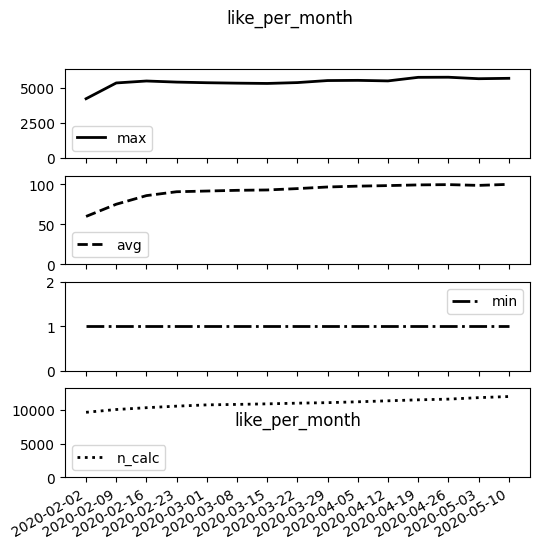

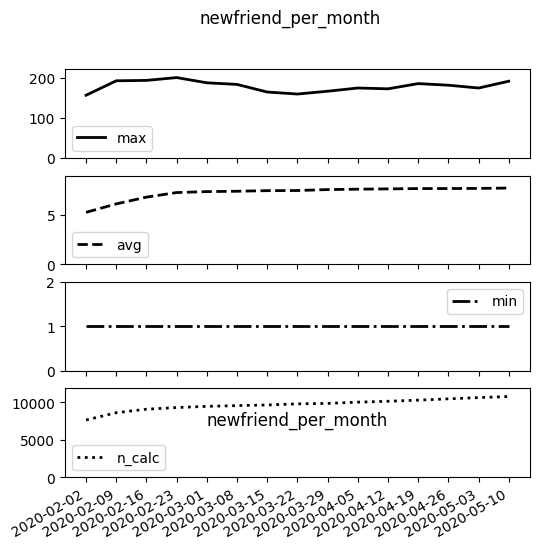

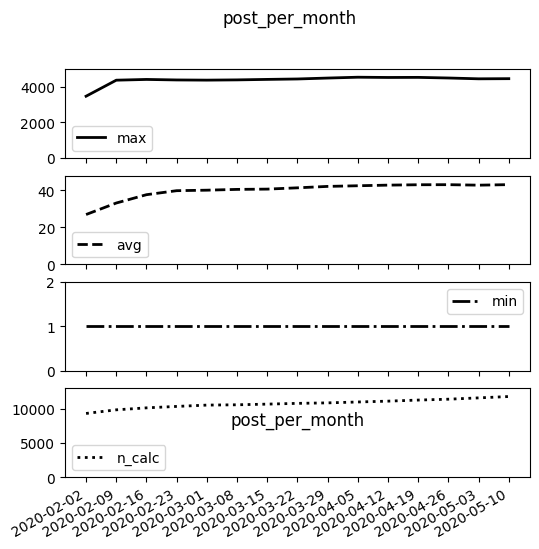

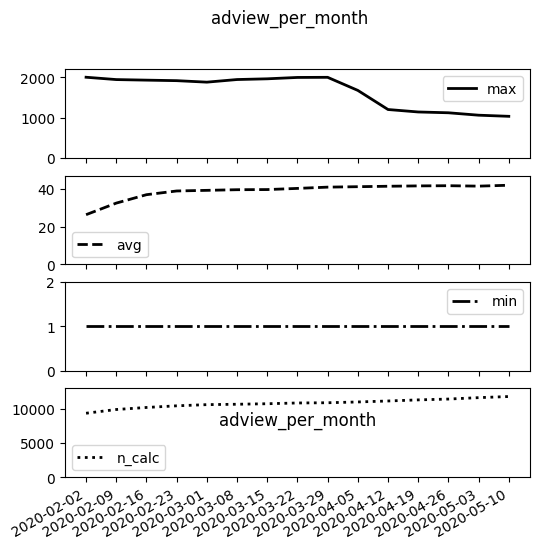

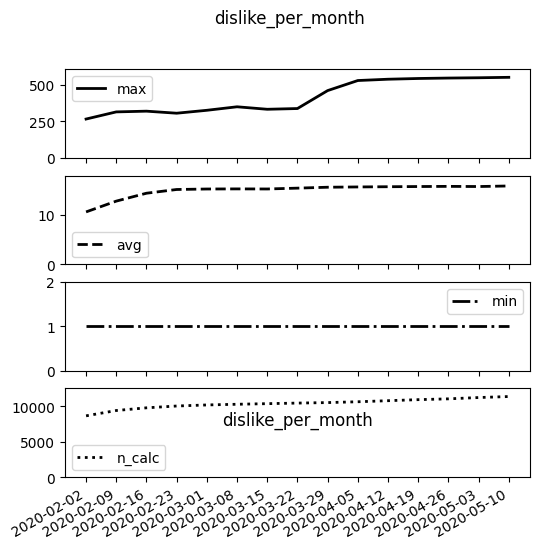

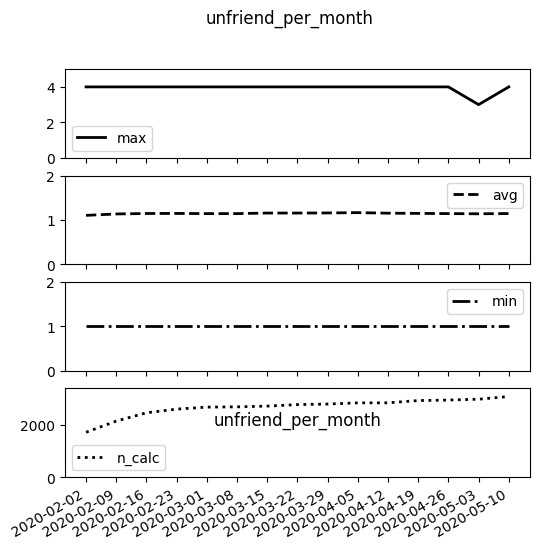

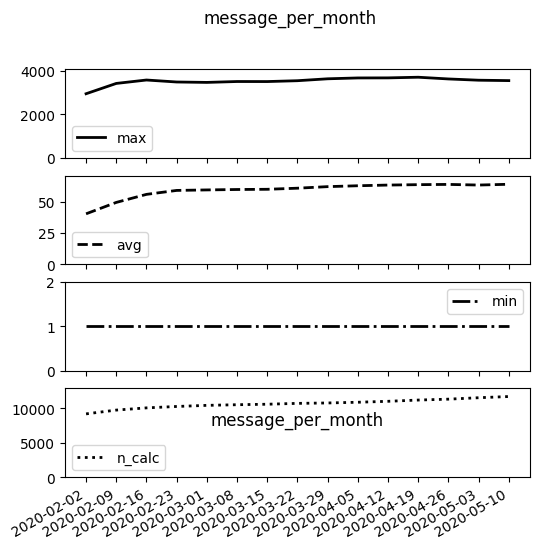

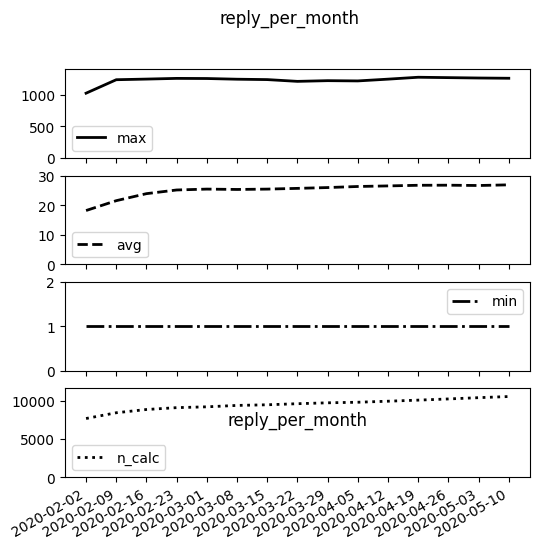

In [46]:
# read in the qa data for the relevant qa metrics:
for metric_name in metrics2measure:
    # read in qa metric from csv
    csv_read_path = '../../output/metric-csvs/' + metric_name + '.csv'
    qa_data_df = pd.read_csv(csv_read_path)


    # set up the figure, create subplots for each qa metric
    plt.figure(figsize=(6, 6))
    qa_subplot(qa_data_df,'max', 1, None) 
    qa_subplot(qa_data_df,'avg', 2, '--')
    qa_subplot(qa_data_df,'min', 3, '-.')
    qa_subplot(qa_data_df,'n_calc', 4, ':')

    # Automatically adjusts the x-axis tick labels to best fit the available space. 
    # Specifically designed for formatting and displaying dates on the x-axis.
    plt.gca().figure.autofmt_xdate()
    plt.title(metric_name, y=0.5)
    plt.suptitle(metric_name, fontsize=12)

    plt.show()